## Notebook for visualizing anchor, buffer, and register tokens

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from transformers import CLIPProcessor, CLIPModel

RETAIN = 192 # Original 576
OBJECT_LAYER = 9
ALPHA = 0.5

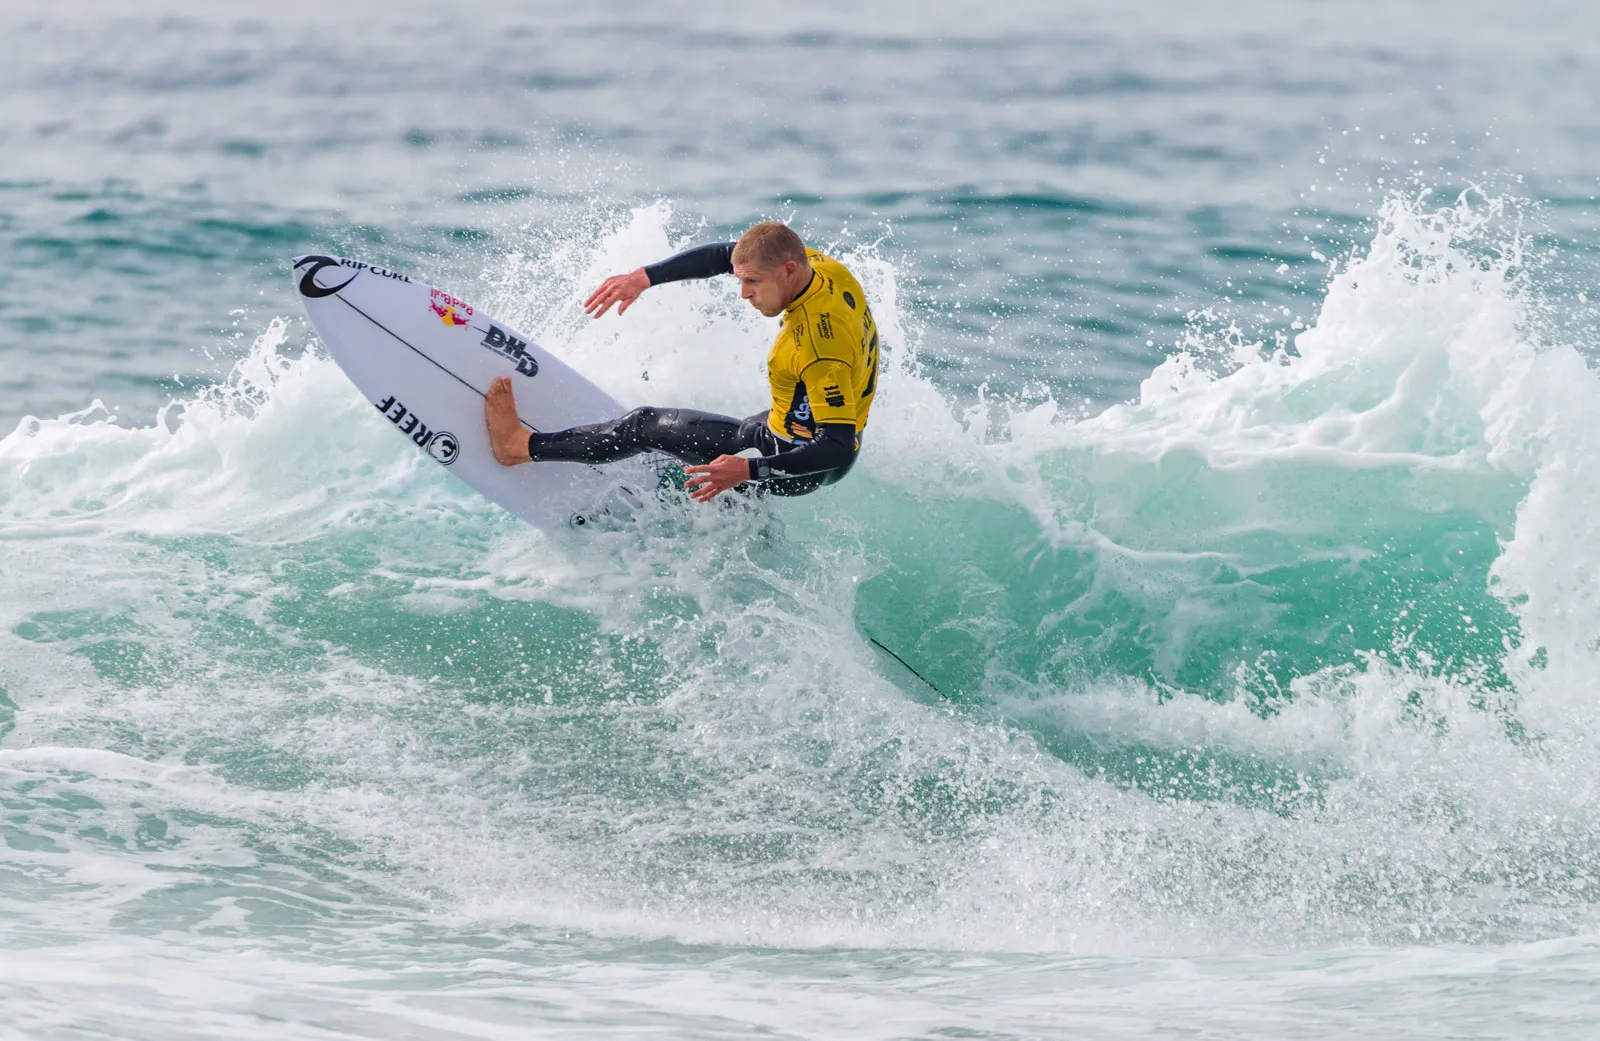

In [8]:
image_path = "../assets/surf.webp"
image = Image.open(image_path)
image

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "openai/clip-vit-large-patch14-336"
model = CLIPModel.from_pretrained(model_name, output_attentions=True).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

inputs = processor(images=image, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model.vision_model(**inputs, output_attentions=True)

attentions = outputs.attentions

### Anchor tokens

In [10]:
mid_attn = attentions[OBJECT_LAYER]
mid_avg_attn = mid_attn.mean(dim=1).squeeze(0)  # (seq_len, seq_len)
attn_score = mid_avg_attn.sum(0)[1:]

anchor_indices = torch.topk(attn_score, k=int(RETAIN * ALPHA / 5)).indices.cpu()
anchor_indices

tensor([154, 155, 131, 198, 218,  23, 252, 245, 151, 129, 374, 153, 144, 250,
        152, 130, 173, 197, 243])

### Buffer tokens

In [11]:
buffer_indices = torch.cat([anchor_indices-1,
                            anchor_indices+1,
                            anchor_indices-24,
                            anchor_indices+24])
valid_buffer = (buffer_indices >= 0) & (buffer_indices <= 575)
buffer_indices = buffer_indices[valid_buffer].unique().cpu()
buffer_indices = buffer_indices[~torch.isin(buffer_indices, anchor_indices)]
buffer_indices

tensor([ 22,  24,  47, 105, 106, 107, 120, 127, 128, 132, 143, 145, 149, 150,
        156, 168, 172, 174, 175, 176, 177, 178, 179, 194, 196, 199, 217, 219,
        221, 222, 226, 228, 242, 244, 246, 249, 251, 253, 267, 269, 274, 276,
        350, 373, 375, 398])

### Register tokens

In [12]:
chosens = torch.cat([anchor_indices, buffer_indices]).unique()
register_num = RETAIN - len(chosens)

deep_attn = attentions[-2] # LLaVA uses tokens from the last but one layer of CLIP
deep_attn = deep_attn.mean(1).squeeze(0)
deep_attn = deep_attn.sum(0)[1:]
deep_attn[chosens] = -1

register_indices = torch.topk(deep_attn, k=register_num).indices.cpu()
register_indices

tensor([ 37,  92,   3, 342,  61, 171, 470, 369, 327, 421, 419, 343,   8,  57,
          4, 336, 225, 204, 571,  80, 147, 170, 413, 203, 229, 224, 113, 412,
         71,  94, 195,  97, 293, 111,   0, 268,  18, 568, 146, 227,  25, 552,
        465, 420, 193, 512, 298, 561, 285,  55, 359, 169,  98, 299,   5, 202,
         43, 136, 300, 504, 133, 339, 349, 148, 541, 114,  88, 216, 486, 566,
        277, 248, 392, 108, 318, 124, 187, 278,  73, 181, 311, 529, 348, 567,
        182, 247, 497, 241,  96, 387,  49, 570, 230, 223, 254, 270, 180, 275,
        256, 399, 562,  48, 326, 430, 239, 122,   7, 207, 259, 319, 191, 297,
        205, 296, 186, 294,  72, 338, 211, 121, 304, 163, 142, 416, 575,  11,
        554])

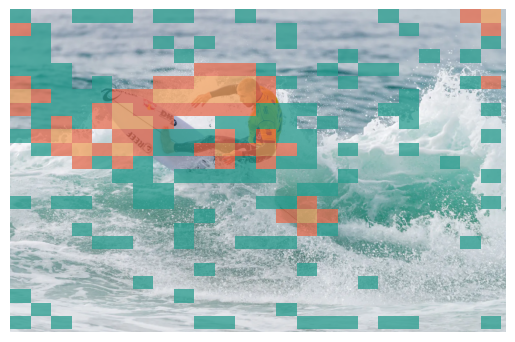

In [13]:
def visualize_token_categories(image: Image.Image,
                               anchor_indices: torch.Tensor,
                               buffer_indices: torch.Tensor,
                               register_indices: torch.Tensor,
                               grid_size: int = 24,
                               patch_alpha: float = 0.75):
    img_np = np.array(image)
    H, W = img_np.shape[:2]
    patch_h, patch_w = H // grid_size, W // grid_size

    fig, ax = plt.subplots()
    ax.imshow(img_np)
    ax.axis('off')

    def draw_boxes(indices, color):
        for idx in indices.tolist():
            row = idx // grid_size
            col = idx % grid_size
            rect = plt.Rectangle((col * patch_w, row * patch_h),
                                 patch_w, patch_h,
                                 linewidth=0,
                                 edgecolor=None,
                                 facecolor=color,
                                 alpha=patch_alpha)
            ax.add_patch(rect)

    draw_boxes(anchor_indices, color='#f3a361')
    draw_boxes(buffer_indices, color='#e66d50')
    draw_boxes(register_indices, color='#299d8f')

    plt.show()

visualize_token_categories(image, anchor_indices, buffer_indices, register_indices)